In [1]:
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline
import numpy as np
import torch
import matplotlib.pyplot as plt

- 生成模拟数据

In [2]:
def linearModel(X: torch.tensor, w: torch.tensor)-> torch.tensor:
    return X@w.reshape(-1, 1)

In [3]:
# 生成数据
true_w = torch.tensor([2, -3.4, 4.2])  # 权重+偏置
num_inputs = true_w.numel()  # 权重数量(true_w中元素个数)
num_examples = 1000  # 样本数量
features = torch.cat([torch.randn(num_examples, num_inputs - 1), torch.ones(num_examples).reshape(-1, 1)], axis=1 ) # 随机生成1000个特征(1000*2) 加上偏置
labels = linearModel(features, true_w) + torch.randn(num_examples).reshape(-1, 1) * 0.01  # 将随机生成的特征输入linearModel，然后加入随机项（表示偏差）

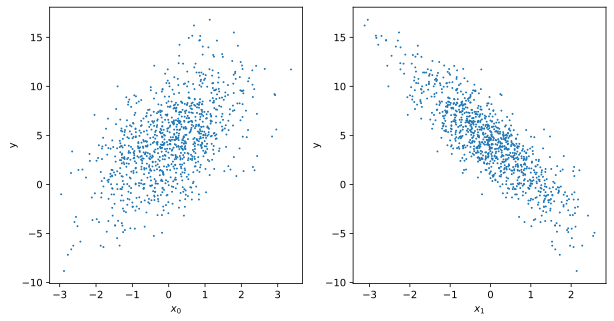

In [4]:
plt.rcParams['figure.figsize'] = (8, 3)
fig = plt.figure(figsize=(10,5))
# y随第1个特征x_0的散点图
ax1 = fig.add_subplot(1, 2, 1)
ax1.set_xlabel("$x_0$")
ax1.set_ylabel("y")
ax1.scatter(features[:, 0].numpy(), labels.numpy(), s=1)
# y随第2个特征x_1的散点图
ax2 = fig.add_subplot(1, 2, 2)
ax2.set_xlabel("$x_1$")
ax2.set_ylabel("y")
ax2.scatter(features[:, 1].numpy(), labels.numpy(), s=1)
fig

- `mse`损失函数

In [5]:
def meanSquaredLoss(X: torch.tensor, y: torch.tensor, w: torch.tensor) -> torch.tensor:
    """
    y: 标签
    """
    hat_y = X @ w.reshape(-1, 1)
    sLoss = torch.dot(hat_y.reshape(-1) - y.reshape(-1), hat_y.reshape(-1) - y.reshape(-1)) / y.numel()
    return sLoss

In [6]:
def grad_mse_w(X, y, w):
    '''
    X: N*a, N为样本数量，a为（增广）特征维度
    y: N
    w: a*1
    '''
    return 2*(X.t()@(X@w.reshape(-1, 1) - y.reshape(-1, 1))) / y.numel()

- 测试函数

In [7]:
def f(x):
    """
    函数: f(x0, x1) = x0**2 + 2*x1**2
    """
    return x[0] ** 2 + 2 * x[1] ** 2  # objective

def grad_f(x):
    """
    f(x)的梯度
    """
    return np.array([2 * x[0], 4 * x[1]])  # gradient

## 1. 梯度下降(gradient descendent)

- 解释1

假设目标函数$f: \mathbb{R}^d \rightarrow \mathbb{R}$的输入是一个$d$维向量$\boldsymbol{x} = [x_1, x_2, \ldots, x_d]^\top$。目标函数$f(\boldsymbol{x})$有关$\boldsymbol{x}$的梯度是一个由$d$个偏导数组成的向量：

$$\nabla_{\boldsymbol{x}} f(\boldsymbol{x}) = \bigg[\frac{\partial f(\boldsymbol{x})}{\partial x_1}, \frac{\partial f(\boldsymbol{x})}{\partial x_2}, \ldots, \frac{\partial f(\boldsymbol{x})}{\partial x_d}\bigg]^\top.$$

为表示简洁，我们用$\nabla f(\boldsymbol{x})$代替$\nabla_{\boldsymbol{x}} f(\boldsymbol{x})$。梯度中每个偏导数元素$\partial f(\boldsymbol{x})/\partial x_i$代表着$f$在$\boldsymbol{x}$有关输入$x_i$的变化率。为了测量$f$沿着单位向量$\boldsymbol{u}$（即$\|\boldsymbol{u}\|=1$）方向上的变化率，在多元微积分中，我们定义$f$在$\boldsymbol{x}$上沿着$\boldsymbol{u}$方向的方向导数为

$$\text{D}_{\boldsymbol{u}} f(\boldsymbol{x}) = \lim_{h \rightarrow 0}  \frac{f(\boldsymbol{x} + h \boldsymbol{u}) - f(\boldsymbol{x})}{h}.$$

以上方向导数可以改写为

$$\text{D}_{\boldsymbol{u}} f(\boldsymbol{x}) = \nabla f(\boldsymbol{x}) \cdot \boldsymbol{u}.$$

方向导数$\text{D}_{\boldsymbol{u}} f(\boldsymbol{x})$给出了$f$在$\boldsymbol{x}$上沿着所有可能方向的变化率。为了最小化$f$，我们希望找到$f$能被降低最快的方向。因此，我们可以通过单位向量$\boldsymbol{u}$来最小化方向导数$\text{D}_{\boldsymbol{u}} f(\boldsymbol{x})$。

由于$\text{D}_{\boldsymbol{u}} f(\boldsymbol{x}) = \|\nabla f(\boldsymbol{x})\| \cdot \|\boldsymbol{u}\|  \cdot \text{cos} (\theta) = \|\nabla f(\boldsymbol{x})\|  \cdot \text{cos} (\theta)$，
其中$\theta$为梯度$\nabla f(\boldsymbol{x})$和单位向量$\boldsymbol{u}$之间的夹角，当$\theta = \pi$时，$\text{cos}(\theta)$取得最小值$-1$。因此，当$\boldsymbol{u}$在梯度方向$\nabla f(\boldsymbol{x})$的相反方向时，方向导数$\text{D}_{\boldsymbol{u}} f(\boldsymbol{x})$被最小化。因此，我们可能通过梯度下降算法来不断降低目标函数$f$的值：

$$\boldsymbol{x} \leftarrow \boldsymbol{x} - \eta \nabla f(\boldsymbol{x}).$$

同样，其中$\eta$（取正数）称作学习率。

- 解释2

考虑$\mathbf{x} \in \mathbb{R}^d$, 其中$\mathbf{x}$为向量, 目标函数$f: \mathbb{R}^d \to \mathbb{R}$映射至标量。对应的$f$关于$\mathbf{x}$每一维度$x_i$的偏导构成梯度

$$\nabla f(\mathbf{x}) = \bigg[\frac{\partial f(\mathbf{x})}{\partial x_1}, \frac{\partial f(\mathbf{x})}{\partial x_2}, \ldots, \frac{\partial f(\mathbf{x})}{\partial x_d}\bigg]^\top.$$

利用泰勒展开式可得

$$f(\mathbf{x} + \Delta x) = f(\mathbf{x}) + \Delta\mathbf{x}^\top \nabla f(\mathbf{x}) + O(|\mathbf{\Delta x}|^2).$$ 

换而言之，最速下降方向由$-\nabla f(\mathbf{x})$给出。令$\Delta \mathbf{x}=-\eta \nabla f(\mathbf{x})$

$$f(\mathbf{x} + \Delta x) = f(\mathbf{x}) - \eta \nabla f(\mathbf{x})^T \nabla f(\mathbf{x}) + O(|\Delta x|^2).$$ 

选定合适的学习率$\eta > 0$，则可得梯度下降更新公式

$$\mathbf{x} \leftarrow \mathbf{x} - \eta \nabla f(\mathbf{x}).$$

批量梯度下降法在每次迭代时需要计算每个样本上损失函数的梯度并求和。当训练集中的样本数量𝑁很大时，空间复杂度比较高，每次迭代的计算开销也很大。

**随机梯度下降**

> $f_i(\boldsymbol{x})$是有关索引为$i$的训练数据样本的损失函数，$n$是训练数据样本数，$\boldsymbol{x}$是模型的参数向量，那么目标函数定义为
> 
> $$f(\boldsymbol{x}) = \frac{1}{n} \sum_{i = 1}^n f_i(\boldsymbol{x}).$$
> 
> 目标函数在$\boldsymbol{x}$处的梯度计算为
> 
>$$\nabla f(\boldsymbol{x}) = \frac{1}{n} \sum_{i = 1}^n \nabla f_i(\boldsymbol{x}).$$
>
> 如果使用梯度下降，每次自变量迭代的计算开销为$\mathcal{O}(n)$，它随着$n$线性增长。因此，当训练数据样本数很大时，梯度下降每次迭代的计算开销很高。
>
> 随机梯度下降（stochastic gradient descent，SGD）减少了每次迭代的计算开销。在随机梯度下降的每次迭代中，我们随机均匀采样的一个样本索引$i\in\{1,\ldots,n\}$，并计算梯度$\nabla f_i(\boldsymbol{x})$来迭代$\boldsymbol{x}$：
>
> $$\boldsymbol{x} \leftarrow \boldsymbol{x} - \eta \nabla f_i(\boldsymbol{x}).$$
>
> 这里$\eta$同样是学习率。可以看到每次迭代的计算开销从梯度下降的$\mathcal{O}(n)$降到了常数$\mathcal{O}(1)$。
>
> 值得强调的是，随机梯度$\nabla f_i(\boldsymbol{x})$是对梯度$\nabla f(\boldsymbol{x})$的无偏估计：
>
> $$E_i \nabla f_i(\boldsymbol{x}) = \frac{1}{n} \sum_{i = 1}^n \nabla f_i(\boldsymbol{x}) = \nabla f(\boldsymbol{x}).$$
>
> 这意味着，平均来说，随机梯度是对梯度的一个良好的估计。

- `numpy`实现

In [8]:
def gd_numpy(f, grad_f, x0, learn_rate=0.05, max_iter=100):
    """
    f: 待优化目标函数, grad_f: f的梯度, x0: 参数初值, learn_rate: 学习率
    """
    trace_x = np.array([x0])  # x的历史记录
    x = x0
    i = 1
    while i <= max_iter:
        x = x - learn_rate * grad_f(x)  # 更新x的值
        trace_x = np.concatenate([trace_x, x.reshape(1, -1)])
        i += 1
        if i % 5 == 0:
            print(f"迭代次数: {i}, 目标函数值f: {f(x):.6f}")

        if np.sum(np.abs(trace_x[-1] - trace_x[-2])) < 1e-5:  # 停止条件
            break

    print(f"共迭代{len(trace_x)}次, 目标函数: {f(x)}, 最优参数值: {x.tolist()}")
    return trace_x

In [9]:
res = gd_numpy(f, grad_f, x0=np.array([3, 3]), learn_rate=0.001)

迭代次数: 5, 目标函数值f: 26.289004
迭代次数: 10, 目标函数值f: 25.428588
迭代次数: 15, 目标函数值f: 24.598558
迭代次数: 20, 目标函数值f: 23.797788
迭代次数: 25, 目标函数值f: 23.025195
迭代次数: 30, 目标函数值f: 22.279738
迭代次数: 35, 目标函数值f: 21.560413
迭代次数: 40, 目标函数值f: 20.866256
迭代次数: 45, 目标函数值f: 20.196341
迭代次数: 50, 目标函数值f: 19.549775
迭代次数: 55, 目标函数值f: 18.925699
迭代次数: 60, 目标函数值f: 18.323288
迭代次数: 65, 目标函数值f: 17.741746
迭代次数: 70, 目标函数值f: 17.180310
迭代次数: 75, 目标函数值f: 16.638244
迭代次数: 80, 目标函数值f: 16.114839
迭代次数: 85, 目标函数值f: 15.609416
迭代次数: 90, 目标函数值f: 15.121319
迭代次数: 95, 目标函数值f: 14.649918
迭代次数: 100, 目标函数值f: 14.194605
共迭代101次, 目标函数: 14.105420993691151, 最优参数值: [2.4557004140652836, 2.0093477138179376]


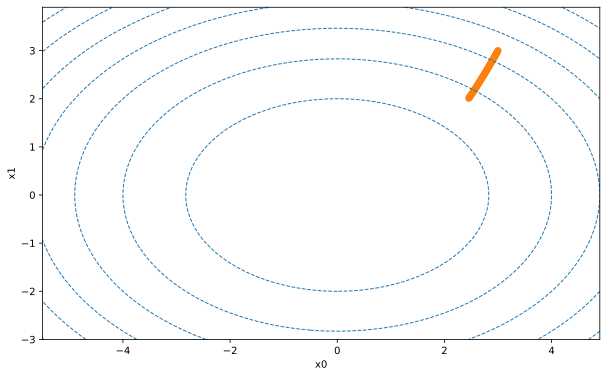

In [11]:
x0, x1 = res[:, 0], res[:, 1]

plt.figure(figsize=(10, 6))
plt.plot(x0, x1, "-o", color="#ff7f0e")
x0 = np.arange(-5.5, 5.0, 0.1)
x1 = np.arange(min(-3.0, min(x1) - 1), max(1.0, max(x1) + 1), 0.1)
x0, x1 = np.meshgrid(x0, x1)
plt.contour(x0, x1, f([x0, x1]), colors="#1f77b4", linewidths=1, linestyles="dashed")
plt.xlabel("x0")
plt.ylabel("x1")
plt.show()

- `torch`实现更通用的优化函数

In [12]:
def grad_desc(lossfunc, w, x_dict, max_iters=200, learn_rate=0.005):
    """
    f: 待优化目标函数, grad_f: f的梯度, w: 参数初值, x_dict:固定参数值, learn_rate: 学习率
    """
    trace_w = w.clone().data.reshape(1, -1)
    i = 0
    for i in range(max_iters):
        l = lossfunc(w=w, **x_dict)
        l.backward()
        w.data.sub_(learn_rate * w.grad.data)
        with torch.no_grad():
            trace_w = torch.cat([trace_w, w.detach().data.reshape(1, -1)], 0)
            if (i + 1) % 10 == 0:
                loss = lossfunc(w=w, **x_dict).data.numpy()
                print(f"迭代次数: {i+1}, 损失函数值: {loss:.4f}")
            
            if torch.sum(torch.abs(trace_w[-1] - trace_w[-2])) < 1e-3:  # 停止条件
                break

        w.grad.zero_()

    print(f"共迭代{i}次, 损失函数值: {lossfunc(w=w, **x_dict).data.numpy():.4f}, 最优参数值: {w.tolist()}")
    return trace_w

In [13]:
w = torch.randn(num_inputs, 1)
w.requires_grad_(True)
trace_w = grad_desc(meanSquaredLoss, w, x_dict = {'X': features, 'y': labels}, learn_rate=0.05)

迭代次数: 10, 损失函数值: 2.6290
迭代次数: 20, 损失函数值: 0.2814
迭代次数: 30, 损失函数值: 0.0305
迭代次数: 40, 损失函数值: 0.0034
迭代次数: 50, 损失函数值: 0.0005
迭代次数: 60, 损失函数值: 0.0001
共迭代61次, 损失函数值: 0.0001, 最优参数值: [[1.9982566833496094], [-3.3970322608947754], [4.196223258972168]]


目标函数有关自变量的梯度代表了目标函数在自变量当前位置下降最快的方向。因此，梯度下降也叫作最陡下降（steepest descent）。在每次迭代中，梯度下降根据自变量当前位置，沿着当前位置的梯度更新自变量。

然而，如果自变量的迭代方向仅仅取决于自变量当前位置，这可能会带来一些问题。

例如，各维度上的梯度变化量不一致带来的学习率的权衡问题：如果设置过大的学习率，则将错过最优点，出现震荡发散；如果设置过小的学习率，则收率缓慢，在给定迭代时间内未达到最优点。因此，后续提出以动量和自适应算法为代表的以修正迭代算法。以下介绍其中的两种代表性算法：gradient descendent with moment和adam。

## 2. 动量梯度下降(gradient descendent with moment)

设时间步$t$的自变量为$\boldsymbol{x}_t$，学习率为$\eta_t$。在时间步$0$，动量法创建速度变量$\boldsymbol{v}_0$，并将其元素初始化成0。在时间步$t>0$，动量法对每次迭代的步骤做如下修改：

$$
\begin{aligned}
\boldsymbol{v}_t &\leftarrow \gamma \boldsymbol{v}_{t-1} + \eta \boldsymbol{g}_t, \\
\boldsymbol{x}_t &\leftarrow \boldsymbol{x}_{t-1} - \boldsymbol{v}_t,
\end{aligned}
$$

其中，$g_t$为梯度，动量超参数$\gamma$满足$0 \leq \gamma < 1$。当$\gamma=0$时，动量法等价于小批量随机梯度下降。

相对于原版梯度下降算法，动量梯度下降算法有如下优点：

- 动量梯度下降算法移动得更快(因为它积累所有动量)
- 动量梯度下降算法有机会逃脱局部极小值(因为动量可能推动它脱离局部极小值)

- `numpy`实现

In [14]:
def gd_momen_numpy(f, grad_f, x0, beta=0.5, learn_rate=0.05, max_iter=100):
    trace_x = np.array([x0])
    x = x0
    m_0 = 0
    i = 1
    while i <= max_iter:
        grad = grad_f(x)
        m_1 = beta*m_0 + learn_rate*grad
        x = x - m_1
        trace_x = np.concatenate([trace_x, x.reshape(1, -1)])
        if i % 5 == 0:
            print(f"迭代次数: {i}, 目标函数值f: {f(x):.6f}")

        if np.sum(np.abs(trace_x[-1] - trace_x[-2])) < 1e-3:  # 停止条件
            break

        m_0 = m_1
        i += 1

    print(f"共迭代{len(trace_x)}次, 目标函数: {f(x)}, 最优参数值: {x.tolist()}")
    return trace_x

In [15]:
res = gd_momen_numpy(f, grad_f, x0=np.array([3, 3]), learn_rate=0.5)

迭代次数: 5, 目标函数值f: 0.597656
迭代次数: 10, 目标函数值f: 0.012394
迭代次数: 15, 目标函数值f: 0.000278
迭代次数: 20, 目标函数值f: 0.000009
迭代次数: 25, 目标函数值f: 0.000000
共迭代27次, 目标函数: 4.1710795617433405e-07, 最优参数值: [0.00036200881004333496, 0.0003781914710998535]


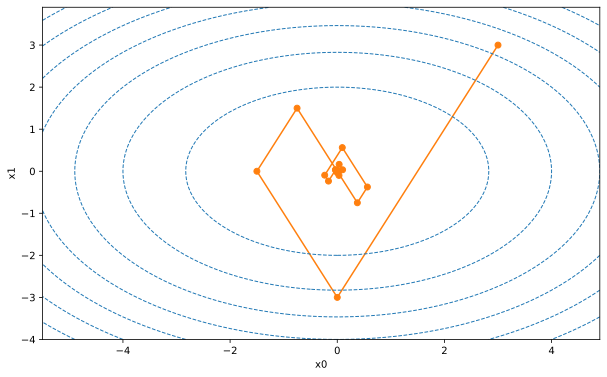

In [16]:
x0, x1 = res[:, 0], res[:, 1]

# display.set_matplotlib_formats("svg")
plt.figure(figsize=(10, 6))
plt.plot(x0, x1, "-o", color="#ff7f0e")
x0 = np.arange(-5.5, 5.0, 0.1)
x1 = np.arange(min(-3.0, min(x1) - 1), max(1.0, max(x1) + 1), 0.1)
x0, x1 = np.meshgrid(x0, x1)
plt.contour(x0, x1, f([x0, x1]), colors="#1f77b4", linewidths=1, linestyles="dashed")
plt.xlabel("x0")
plt.ylabel("x1")
plt.show()

- `torch`实现更通用版本

In [17]:
def grad_desc_with_momentum(lossfunc, w, x_dict, beta=0.5, learn_rate=0.05, max_iter=1000):
    trace_w = w.clone().data.reshape(1, -1)
    v_0 = 0
    i = 1
    while i <= max_iter:
        l = lossfunc(w=w, **x_dict)
        l.backward()
        v_1 = beta*v_0 + learn_rate*w.grad.data
        w.data.sub_(v_1)
        with torch.no_grad():
            trace_w = torch.cat([trace_w, w.detach().data.reshape(1, -1)], 0)
            if i % 10 == 0:
                loss = lossfunc(w=w, **x_dict).data.numpy()
                print(f"迭代次数: {i}, 损失函数值: {loss:.4f}")
            
            if torch.sum(torch.abs(trace_w[-1] - trace_w[-2])) < 1e-3:  # 停止条件
                break

        w.grad.zero_()
        v_0 = v_1
        i += 1

    print(f"共迭代{i-1}次, 损失函数值: {lossfunc(w=w, **x_dict).data.numpy():.4f}, 最优参数值: {w.tolist()}")
    return trace_w

In [18]:
w = torch.randn(num_inputs, 1)
w.requires_grad_(True)
trace_w = grad_desc_with_momentum(meanSquaredLoss, w, x_dict={'X': features, 'y': labels}, learn_rate=0.05)

迭代次数: 10, 损失函数值: 0.1038
迭代次数: 20, 损失函数值: 0.0002
共迭代24次, 损失函数值: 0.0001, 最优参数值: [[2.0004308223724365], [-3.4009571075439453], [4.200863838195801]]


## 3. 适应性动量梯度下降(adaptive gradient descendent with moment)

给定超参数$0 \leq \beta_1 < 1$（算法作者建议设为0.9），时间步$t$的动量变量$\boldsymbol{v}_t$即小批量随机梯度$\boldsymbol{g}_t$的指数加权移动平均：

$$\boldsymbol{v}_t \leftarrow \beta_1 \boldsymbol{v}_{t-1} + (1 - \beta_1) \boldsymbol{g}_t. $$

给定超参数$0 \leq \beta_2 < 1$（算法作者建议设为0.999），将小批量随机梯度按元素平方后的项$\boldsymbol{g}_t \odot \boldsymbol{g}_t$做指数加权移动平均得到$\boldsymbol{s}_t$：

$$\boldsymbol{s}_t \leftarrow \beta_2 \boldsymbol{s}_{t-1} + (1 - \beta_2) \boldsymbol{g}_t \odot \boldsymbol{g}_t. $$

由于我们将$\boldsymbol{v}_0$和$\boldsymbol{s}_0$中的元素都初始化为0，
在时间步$t$我们得到
$$\boldsymbol{v}_t =  (1-\beta_1) \sum_{i=1}^t \beta_1^{t-i} \boldsymbol{g}_i.$$

将过去各时间步小批量随机梯度的权值相加，得到 
$$(1-\beta_1) \sum_{i=1}^t \beta_1^{t-i} = 1 - \beta_1^t.$$

需要注意的是，当$t$较小时，过去各时间步小批量随机梯度权值之和会较小。例如，当$\beta_1 = 0.9$时，$\boldsymbol{v}_1 = 0.1\boldsymbol{g}_1$。为了消除这样的影响，对于任意时间步$t$，我们可以将$\boldsymbol{v}_t$再除以$1 - \beta_1^t$，从而使过去各时间步小批量随机梯度权值之和为1。这也叫作**偏差修正**。在Adam算法中，我们对变量$\boldsymbol{v}_t$和$\boldsymbol{s}_t$均作偏差修正：
$$\hat{\boldsymbol{v}}_t \leftarrow \frac{\boldsymbol{v}_t}{1 - \beta_1^t}, $$

$$\hat{\boldsymbol{s}}_t \leftarrow \frac{\boldsymbol{s}_t}{1 - \beta_2^t}. $$

接下来，Adam算法使用以上偏差修正后的变量$\hat{\boldsymbol{v}}_t$和$\hat{\boldsymbol{s}}_t$，将模型参数中每个元素的学习率通过按元素运算重新调整：

$$\boldsymbol{g}_t' \leftarrow \frac{\eta \hat{\boldsymbol{v}}_t}{\sqrt{\hat{\boldsymbol{s}}_t} + \epsilon},$$

其中$\eta$是学习率，$\epsilon$是为了维持数值稳定性而添加的常数，如$10^{-8}$。目标函数自变量中每个元素都分别拥有自己的学习率。最后，使用$\boldsymbol{g}_t'$迭代自变量：

$$\boldsymbol{x}_t \leftarrow \boldsymbol{x}_{t-1} - \boldsymbol{g}_t'. $$

## ADAM的原理

ADAM结合了动量和自适应学习率两种技术

### 1. 核心思想
自适应动量方法同时维护两个信息：
- 一阶动量（梯度的指数移动平均）：保持更新方向的一致性
- 二阶动量（梯度平方的指数移动平均）：自适应调整每个参数的学习率

关键创新：为每个参数独立地调整学习率，基于历史梯度的大小。

---

### 2. Adam 算法详解

#### 更新公式：

初始化：$m_0 = 0, v = 0$

在第 t 步：
1. 计算梯度：$g_t = \nabla L(\theta_t)$
2. 更新一阶动量：$m_t = \beta_1 \cdot m_{t-1} + (1-\beta_1) \cdot g_t$
3. 更新二阶动量：$v_t = \beta_2 \cdot v_{t-1} + (1-\beta_2) \cdot g_t^2$
4. 偏差修正：$m̂_t = m_t/(1-\beta_1^t), v̂_t = v_t/(1-\beta_2^t)$
5. 参数更新：$\theta_{t+1} = \theta_t - \eta \cdot m̂_t/(\sqrt{v̂_t} + \epsilon)$

#### 各部分作用：
- $m_t$（一阶动量）：梯度的指数加权平均，提供更新的方向和动量
- $v_t$（二阶动量）：梯度平方的指数加权平均，估计每个参数的梯度幅度
- 偏差修正：初始阶段 $m$ 和 $v$ 偏向 0，需要修正
- 自适应学习率：$\eta/\sqrt{v_t}$ 使得梯度大的参数学习率自动变小

---

### 3. 为什么说是"自适应"？

#### 自适应特性体现在：
1. 参数级别的学习率调整：
   - 梯度持续大的参数 → $v_t$ 大 → 学习率自动降低
   - 梯度持续小的参数 → $v_t$ 小 → 学习率自动提高

2. 对稀疏梯度友好：
   - 稀疏特征得到更大的学习率
   - 频繁更新的特征学习率逐渐降低

3. 自动适应损失函数曲率：
   - 陡峭方向（梯度变化大）→ 自动减小步长
   - 平缓方向（梯度变化小）→ 自动增大步长

---

### 4. 与其他方法对比

| 算法 | 一阶动量 | 二阶动量 | 自适应性 | 特点 |
|------|---------|---------|---------|------|
| SGD | ✗ | ✗ | ✗ | 最基础 |
| Momentum | ✓ | ✗ | ✗ | 加速收敛，减少震荡 |
| AdaGrad | ✗ | ✓ | ✓ | 学习率单调递减 |
| RMSProp | ✗ | ✓ | ✓ | 解决 AdaGrad 学习率衰减过快 |
| Adam | ✓ | ✓ | ✓ | 综合 Momentum + RMSProp |
| AdamW | ✓ | ✓ | ✓ | Adam + 权重衰减解耦 |

---

### 5. 直观理解

想象你在一个山谷里找最低点：
- 普通梯度下降：像个醉汉，每步只看当前坡度
- 动量梯度下降：像个有惯性的球，会冲过小坑
- 自适应梯度下降：每个方向用不同步长，陡的方向小步走
- Adam（自适应动量）：既有惯性又会自动调整各方向步长的智能球

#### 优势：
- ✅ 对超参数不太敏感（默认值通常就很好）
- ✅ 适合稀疏梯度和非平稳目标
- ✅ 计算效率高，内存占用合理
- ✅ 适合大规模数据和参数

#### 潜在问题：
- ⚠️ 某些情况下可能不收敛到最优（需要调整 ε 或学习率）
- ⚠️ 二阶动量可能累积过多历史信息
- ⚠️ 在某些任务上 SGD+Momentum 泛化性能更好

---

### 6. 实践建议

默认超参数（通常效果就很好）：
- $\beta_1 = 0.9$（一阶动量系数）
- $\beta_2 = 0.999$（二阶动量系数）
- $\epsilon = 1e-8$（数值稳定性）
- $\eta = 0.001$（初始学习率）


## 什么时候用 Adam?
- 训练 Transformer、BERT 等大模型
- 稀疏数据（如 NLP、推荐系统）
- 需要快速收敛的原型验证

## 什么时候考虑其他?

- 计算机视觉的 CNN：SGD+Momentum 有时泛化更好
- 需要极致泛化性能：可尝试 SGD 或 AdamW
- 资源受限：SGD 内存占用最少


- `numpy`实现

In [19]:
def adam_numpy(f, grad_f, x0, beta1=0.9, beta2=0.999, learn_rate=0.05, max_iter=100, epsilon=1e-8):
    trace_x = np.array([x0])
    x = x0
    m_0, v_0 = 0, 0
    i = 1
    while i <= max_iter:
        grad = grad_f(x)
        m_1 = (beta1 * m_0 + (1 - beta1) * grad) / (1 - beta1**i)
        v_1 = (beta2 * v_0 + (1 - beta2) * grad**2) / (1 - beta2**i)
        x = x - learn_rate * m_1 / (np.sqrt(v_1) + epsilon)
        trace_x = np.concatenate([trace_x, x.reshape(1, -1)])
        if i % 5 == 0:
            print(f"迭代次数: {i}, 目标函数值f: {f(x):.6f}")

        if np.sum(np.abs(trace_x[-1] - trace_x[-2])) < 1e-3:  # 停止条件
            break

        m_0, v_0 = m_1, v_1
        i += 1

    print(f"共迭代{len(trace_x)}次, 目标函数: {f(x)}, 最优参数值: {x.tolist()}")
    return trace_x

In [20]:
res = adam_numpy(f, grad_f, x0=np.array([3, 3]), beta1=0.6, beta2=0.5, max_iter=200, learn_rate=0.3)

迭代次数: 5, 目标函数值f: 2.485937
迭代次数: 10, 目标函数值f: 1.049189
迭代次数: 15, 目标函数值f: 0.153593
迭代次数: 20, 目标函数值f: 0.000938
迭代次数: 25, 目标函数值f: 0.012662
迭代次数: 30, 目标函数值f: 0.000254
迭代次数: 35, 目标函数值f: 0.005913
迭代次数: 40, 目标函数值f: 0.011896
迭代次数: 45, 目标函数值f: 0.000084
迭代次数: 50, 目标函数值f: 0.007040
迭代次数: 55, 目标函数值f: 0.010319
迭代次数: 60, 目标函数值f: 0.000000
迭代次数: 65, 目标函数值f: 0.008121
迭代次数: 70, 目标函数值f: 0.009041
迭代次数: 75, 目标函数值f: 0.000104
迭代次数: 80, 目标函数值f: 0.009186
迭代次数: 85, 目标函数值f: 0.007669
迭代次数: 90, 目标函数值f: 0.000367
迭代次数: 95, 目标函数值f: 0.010275
迭代次数: 100, 目标函数值f: 0.006237
迭代次数: 105, 目标函数值f: 0.000733
迭代次数: 110, 目标函数值f: 0.011310
迭代次数: 115, 目标函数值f: 0.004817
迭代次数: 120, 目标函数值f: 0.001177
迭代次数: 125, 目标函数值f: 0.012166
迭代次数: 130, 目标函数值f: 0.003479
迭代次数: 135, 目标函数值f: 0.001717
迭代次数: 140, 目标函数值f: 0.012701
迭代次数: 145, 目标函数值f: 0.002353
迭代次数: 150, 目标函数值f: 0.002403
迭代次数: 155, 目标函数值f: 0.012775
迭代次数: 160, 目标函数值f: 0.001521
共迭代162次, 目标函数: 0.001478762143320558, 最优参数值: [-0.02220171020780644, -0.022201871623459372]


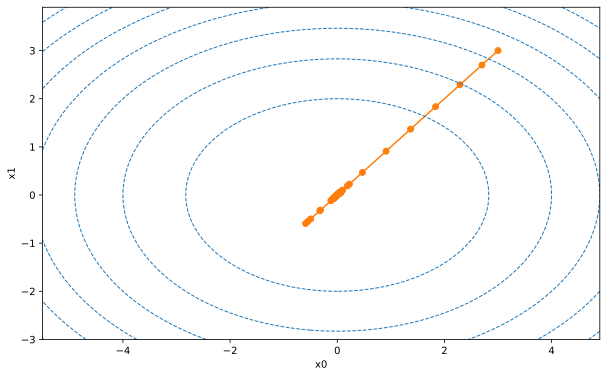

In [21]:
x0, x1 = res[:, 0], res[:, 1]
# display.set_matplotlib_formats("svg")
plt.figure(figsize=(10, 6))
plt.plot(x0, x1, "-o", color="#ff7f0e")
x0 = np.arange(-5.5, 5.0, 0.1)
x1 = np.arange(min(-3.0, min(x1) - 1), max(1.0, max(x1) + 1), 0.1)
x0, x1 = np.meshgrid(x0, x1)
plt.contour(x0, x1, f([x0, x1]), colors="#1f77b4", linewidths=1, linestyles="dashed")
plt.xlabel("x0")
plt.ylabel("x1")
plt.show()

- `torch`实现更通用版本

In [ ]:
def adaptive_momentum(lossfunc, w, x_dict, beta1=0.5, beta2=0.9, learn_rate=0.999, max_iter=1000, epsilon=1e-8):
    trace_w = w.clone().data.reshape(1, -1)
    v_0, s_0 = 0, 0
    i = 1
    while i <= max_iter:
        l = lossfunc(w=w, **x_dict)
        l.backward() 
        v_1 = (beta1*v_0 + (1 - beta1)*w.grad.data) / (1 - beta1**i)
        s_1 = (beta2*s_0 + (1 - beta2)*w.grad.data**2) / (1 - beta2**i)
        w.data.sub_(learn_rate * v_1/(torch.sqrt(s_1) + epsilon))
        with torch.no_grad():
            trace_w = torch.cat([trace_w, w.detach().data.reshape(1, -1)], 0)
            if i % 10 == 0:
                loss = lossfunc(w=w, **x_dict).data.numpy()
                print(f"迭代次数: {i}, 损失函数值: {loss:.4f}")
            
            if torch.sum(torch.abs(trace_w[-1] - trace_w[-2])) < 1e-3:  # 停止条件
                break

        w.grad.zero_()
        v_0, s_0 = v_1, s_1
        i += 1

    print(f"共迭代{i - 1}次, 损失函数值: {lossfunc(w=w, **x_dict).data.numpy():.4f}, 最优参数值: {w.tolist()}")
    return trace_w

In [23]:
w = torch.randn(num_inputs, 1)
w.requires_grad_(True)
trace_w = adaptive_momentum(meanSquaredLoss, w, x_dict={'X': features, 'y': labels})

迭代次数: 10, 损失函数值: 14.9253
迭代次数: 20, 损失函数值: 13.7509
迭代次数: 30, 损失函数值: 12.8042
迭代次数: 40, 损失函数值: 11.6086
迭代次数: 50, 损失函数值: 9.9418
迭代次数: 60, 损失函数值: 7.6850
迭代次数: 70, 损失函数值: 4.9636
迭代次数: 80, 损失函数值: 2.3349
迭代次数: 90, 损失函数值: 0.6175
迭代次数: 100, 损失函数值: 0.0531
迭代次数: 110, 损失函数值: 0.0004
共迭代115次, 损失函数值: 0.0001, 最优参数值: [[1.999524474143982], [-3.401027202606201], [4.200621128082275]]


## 4. 其它优化算法
- 网格搜索
- 遗传算法
- 粒子群算法
- 模拟退火算法
- 蚁群算法

In [ ]:
def f(x):
    """
    函数: f(x0, x1) = x0**2 + 2*x1**2
    """
    return x[0] ** 2 + 2 * x[1] ** 2  # objective

In [60]:
grids = [(x, y) for x in np.linspace(-2, 2, num=100) for y in np.linspace(-2, 2, num=100)]
res = [(f(x), x) for x in grids]    
sorted(res, key=lambda x:x[0])[0]

(0.001224364860728486, (-0.02020202020202011, -0.02020202020202011))

## 参考资料
1. 李航. 统计学习方法. 2017.
2. [阿斯顿·张、李沐、扎卡里 C. 立顿、亚历山大 J. 斯莫拉等. 动手学深度学习. 2020.](https://github.com/d2l-ai/d2l-zh)